In [21]:
%matplotlib inline
%run __init__.py
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas
import utils
from utils import loading, scoring
from gerkin import dream,fit1,fit2,params

In [6]:
descriptors = loading.get_descriptors(format=True)
letters = utils.letters
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
mdx_drag_morg = dream.get_molecular_data(['dragon','morgan'],all_CIDs)

Morgan has 2437 features for 476 molecules.
There are now 7307 total features.


### Load data and parameters

In [7]:
# Create the training data (non-replicated molecules)
X_train,good1,good2,means,stds,imputer = dream.make_X(mdx_drag_morg,['training-norep','leaderboard'])

# Create the testing data (replicated molecules); intensity separate from all other descriptors
X_test_other,good1,good2,means,stds,imputer = dream.make_X(mdx_drag_morg,"replicated",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_test_int,good1,good2,means,stds,imputer = dream.make_X(mdx_drag_morg,"replicated",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)

The X matrix now has shape (774x5497) molecules by non-NaN good molecular descriptors
The X matrix now has shape (20x5497) molecules by non-NaN good molecular descriptors
The X matrix now has shape (15x5497) molecules by non-NaN good molecular descriptors


In [27]:
# Same as above, but preparing data for the linear model
X_train_lin = dream.quad_prep(mdx_drag_morg,sets=['training-norep','leaderboard'])
X_test_lin_other = dream.quad_prep(mdx_drag_morg,sets='replicated',dilution='high')
X_test_lin_int = dream.quad_prep(mdx_drag_morg,sets='replicated',dilution=-3)

The X matrix now has shape (774x14614) molecules by non-NaN good molecular descriptors
The X matrix now has shape (20x14614) molecules by non-NaN good molecular descriptors
The X matrix now has shape (15x14614) molecules by non-NaN good molecular descriptors


In [13]:
# Create descriptor matrices for the training set.  
# One is done with median imputation, and the other by masking missing values.  
Y_train_imp,imputer = dream.make_Y_obs(['training-norep','leaderboard'],target_dilution=None,imputer='median')
Y_train_mask,imputer = dream.make_Y_obs(['training-norep','leaderboard'],target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (774x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (774x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (774x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (774x21) molecules by perceptual descriptors, one for each subject


In [14]:
# Create descriptor matrices for the leaderboard set.  
# One is done with median imputation, and the other with no imputation 
Y_test_other,imputer = dream.make_Y_obs('replicated',target_dilution='high',imputer='mask')
Y_test_int,imputer = dream.make_Y_obs('replicated',target_dilution=-3,imputer='mask')

The Y['mean_std'] matrix now has shape (20x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (20x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (15x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (15x21) molecules by perceptual descriptors, one for each subject


In [15]:
# Load optimal parameters (from cross-validation) for random forest model
trans_params = params.get_trans_params(Y_train_mask, descriptors, plot=False)
use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()

In [19]:
# Load the data into a n_subjects x n_molecules x n_descriptors x n_dilutions x n_replications matrix.  
# This is masked so only gold standard (1/1000 for intensity, high for every other descriptor) is visible, 
# and only for the 20 replicated molecules.  Every other entry is masked and will not affect any calculation.  
data = loading.load_data_matrix(gold_standard_only=True, only_replicates=True)

# Indices of the replicated molecules
rep_indices = np.where(data[0,:,1,:,0].mean(axis=1).mask == False)[0]

In [20]:
# Create a mask to indicate which molecules have intensity values at 1/1000 dilution
CIDs_with_1000fold = [int(x.split('_')[0]) for x in loading.get_CID_dilutions('replicated') if '-3' in x]
CIDs = loading.get_CIDs('replicated')
intensity_mask = [i for i,x in enumerate(CIDs) if x in CIDs_with_1000fold]

### Load or run random forest model

In [28]:
use_saved_rf_model = True
if use_saved_rf_model:
    with open('../../data/rfcs_norep_1.pickle','rb') as f:
        rfcs_norep_1 = pickle.load(f)
else:
    n_estimators = 25
    rfcs_norep_1,score_1,rs_1 = fit1.rfc_final(X_train,Y_train_imp['subject'],
                                max_features,min_samples_leaf,max_depth,use_et,regularize,
                                n_estimators=n_estimators)
    with open('../../data/rfcs_norep_1.pickle','wb') as f:
        pickle.dump(rfcs_norep_1,f)

In [40]:
# Use the model to create the prediction arrays
Y_pred_dec = loading.make_prediction_files(rfcs_norep_1,X_test_int,X_test_other,
                                         'replicated',1,intensity_mask=intensity_mask,Y_test=None,
                                          write=False,regularize=regularize)

In [41]:
# Turn the prediction arrays into a single 3D prediction array

y_pred_dec = np.ma.dstack([Y_pred_dec['subject'][i] for i in range(1,50)])
y_obs_1 = np.ma.dstack([Y_test_other['subject'][i] for i in range(1,50)])
y_obs_1.mask[:,0,:] = True

# There are 20 replications for the high concentration, but only 15 for the 1/1000
# concentration, so these have to be computed separately.  
for i in range(49):
    y_obs_1[intensity_mask,0,i] = Y_test_int['subject'][i+1][:,0]

# Print a summary of the prediction quality
scoring.score_summary(y_pred_dec,y_obs_1,mask=True)

'Score: 29.384339; rs = 0.389,0.408,0.186'

### Linear (Quadratic) model

In [34]:
# Load or compute the feature ranks for the training set
use_saved_linear_feature_ranks = False
if use_saved_linear_feature_ranks:
    lin_ranked = np.load('../../data/lin_ranked_test_retest.npy')
else:
    # -1 is to leave out the leak feature
    lin_ranked = fit1.compute_linear_feature_ranks(X_train_lin[:,:-1],Y_train_mask['mean_std'],n_resampling=10)
    np.save('../../data/lin_ranked_test_retest',lin_ranked)

Computing feature ranks for descriptor #0
Computing feature ranks for descriptor #1
Computing feature ranks for descriptor #2
Computing feature ranks for descriptor #3
Computing feature ranks for descriptor #4
Computing feature ranks for descriptor #5
Computing feature ranks for descriptor #6
Computing feature ranks for descriptor #7
Computing feature ranks for descriptor #8
Computing feature ranks for descriptor #9
Computing feature ranks for descriptor #10
Computing feature ranks for descriptor #11
Computing feature ranks for descriptor #12
Computing feature ranks for descriptor #13
Computing feature ranks for descriptor #14
Computing feature ranks for descriptor #15
Computing feature ranks for descriptor #16
Computing feature ranks for descriptor #17
Computing feature ranks for descriptor #18
Computing feature ranks for descriptor #19
Computing feature ranks for descriptor #20


In [90]:
# Run the linear model (fast)
y_pred_lin = fit2.compute_linear_predictions(X_train_lin,X_test_lin_int,X_test_lin_other,Y_train_imp,
                                lin_ranked,alpha=10.0,max_features=1000)

### Make a consensus model and then compute correlations

In [91]:
# Use an average of the two models as the prediction
y_pred = (y_pred_dec + y_pred_lin)/2

In [92]:
# Compute model/test correlations and test/retest correlations

# Extract the indices of the 20 replicated molecules.  
rep_indices = np.where(data[0,:,1,:,0].mean(axis=1).mask == False)[0]

# Subchallenge 1: Jacknife samples of the Coefficients of Error.
sc1_cv = np.empty(21) # Empty array of length 21.  Will hold Model vs. Test
trt1_cv = np.empty(21) # Empty array of length 21.  Will hold Test vs Retest

for d in range(21): # Iterate over each descriptor.  
    mses_sc1 = np.ma.masked_all(49) # Empty masked array to hold model vs test correlations for each the 49 subjects.  
    mses_trt = np.ma.masked_all(49) # Empty masked array to hold test vs retest correlations for each the 49 subjects.  
    for s in range(49): # Iterate over subjects.  
        o = data[s,rep_indices,d,:,0] # Select test (first trial values) for the replicated molecules.  
        r = data[s,rep_indices,d,:,1] # Select retest (first trial values) for the replicated molecules.  
        o = o.mean(axis=1) # Collapse the dilution dimension.  All non-gold standard dilutions are masked anyway.  
        r = r.mean(axis=1) # Collapse the dilution dimension. All non-gold standard dilutions are masked anyway.  
        p = y_pred[:,d,s] # Select the predicted values for the same molecules. (y_pred_1 has those 20 molecules)  
        
        # To avoid biasing towards test or retest, compute the length-40 vector of concatenated test and retest
        # values for this subject/descriptor.  Compute correlated of corresponding length-40 vector which just has
        # the 20 predicted values listed twice.  
        mses_sc1[s] = np.ma.corrcoef(np.ma.concatenate((o,r)),
                                     np.ma.concatenate((p,p)))[0,1]
        
        # Now compute correlation between test and retest.  
        mses_trt[s] = np.ma.corrcoef(o,r)[0,1]
    
    # Compute the mean across subjects of these within-subject correlations.
    sc1_cv[d] = mses_sc1.mean()
    trt1_cv[d] = mses_trt.mean()

In [76]:
# Same as above, but to compute jacknife samples to get error bars.

sc1_cv_jn = np.ma.empty((21,20)) # Empty masked array of length 21.  Model vs. Test
trt1_cv_jn = np.ma.empty((21,20)) # Empty masked array of length 21.  Test vs Retest

for d in range(21):
    dil = slice(None)#1 if d==0 else slice(None)
    for i in range(20):
        indices = [j for j in range(20) if j!=i]
        mses_sc1 = np.ma.masked_all(49)
        mses_trt = np.ma.masked_all(49)
        for s in range(49):
            o = data[s,rep_indices,d,dil,0]
            r = data[s,rep_indices,d,dil,1]
            o = o.mean(axis=1) # Collapse the dilution dimension
            r = r.mean(axis=1) # Collapse the dilution dimension
            p = y_pred[:,d,s]
            
            if not o.mask[i]:
                mses_sc1[s] = np.ma.corrcoef(np.ma.concatenate((o[indices],r[indices])),
                                             np.ma.concatenate((p[indices],p[indices])))[0,1]
                mses_trt[s] = np.ma.corrcoef(o[indices],r[indices])[0,1]

        sc1_cv_jn[d,i] = mses_sc1.mean()
        trt1_cv_jn[d,i] = mses_trt.mean()

In [75]:
# Make sure that means of jackknife samples are approximately equal to directly computed means
assert np.allclose(sc1_cv,sc1_cv_jn.mean(axis=1),atol=0.05)
assert np.allclose(trt1_cv,trt1_cv_jn.mean(axis=1),atol=0.05)

In [86]:
# Code for plotting the test-retest plot
def plot_r(sc_mean,trt_mean,subchallenge,sc_err=None,trt_err=None,scale='auto'):
    plt.figure(figsize=(12,12))
    x = np.linspace(-1,1,100)
    plt.plot(x,x,'--',c='r',linewidth=4)
    plt.errorbar(trt_mean,sc_mean,xerr=trt_err,yerr=sc_err,c='white',ecolor='black',fmt='o',markersize=15)  
    plt.xlabel('Test-Retest Correlation',size=30)
    plt.ylabel('Model-Test Correlation',size=30)
    plt.xlim(0,0.7)
    plt.ylim(0,0.7)
    from scipy.stats import linregress, ttest_rel
    _,p = ttest_rel(sc_mean,trt_mean)
    r = np.corrcoef(sc_mean,trt_mean)[0,1]
    z = np.zeros(100) # Add 0's for stablility
    coefs = linregress(np.concatenate((z,trt_mean)),np.concatenate((z,sc_mean))) # Zeros force the intercept to be zero
    plt.plot(x,x*coefs.slope + coefs.intercept,'-',c='k')
    plt.text(0.4,0.01,'r = %.3f\nslope = %.2f+/-%.2f' % (r,coefs.slope,coefs.stderr),size=22)
    for i in range(21):
        plt.text(trt_mean[i],sc_mean[i],letters[i],fontdict={'color':'blue','size':12,'weight':'bold'},
                 horizontalalignment='center',verticalalignment='center')

## Fig. 5B

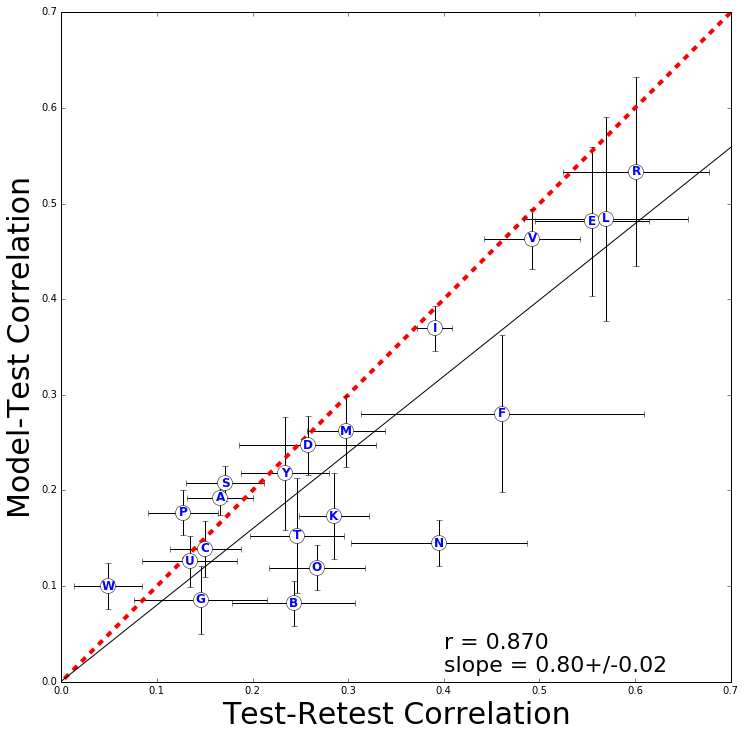

In [93]:
plot_r(sc1_cv_jn.mean(axis=1),trt1_cv_jn.mean(axis=1),1,sc_err=sc1_cv_jn.std(axis=1),trt_err=trt1_cv_jn.std(axis=1))
plt.savefig('../../figures/test-retest.eps',format='eps')

In [94]:
# p-values for each of the points in the plot
# Compared against the null-hypothesis that they are on the line
from scipy.stats import multivariate_normal,chi2
n_rvs = 1000000
ps = np.zeros(21)
for d in range(21):
    rvs = multivariate_normal.rvs([sc1_cv_jn.mean(axis=1)[d],trt1_cv_jn.mean(axis=1)[d]],
                                  [[sc1_cv_jn.std(axis=1)[d]**2,0],
                                   [0,trt1_cv_jn.std(axis=1)[d]**2]],
                                  n_rvs)
    ps[d] = ((rvs[:,1] - rvs[:,0]) < 0).sum()/n_rvs
ps_fdr = np.zeros(21)
for d in range(21):
    ps_fdr[d] = ps[d] * 21 / (1+list(np.argsort(ps)).index(d))
    if ps_fdr[d] < 0.001: 
        stars = '***'
    elif ps_fdr[d] < 0.01: 
        stars = '**'
    elif ps_fdr[d] < 0.05: 
        stars = '*'
    else:
        stars = ''
    print("%s: %.4f %s" % (descriptors[d],ps_fdr[d],stars))
    #print("%s: %.4f (%.4f) %s" % (descriptors[d],ps[d],ps_fdr[d],stars))

fisher = -np.log(ps).sum()*2
print("Pooled p = %.3g" % (1-chi2.cdf(fisher,42)))

fisher = -np.log(ps[1:]).sum()*2
print("Pooled p = %.3g (ignoring intensity)" % (1-chi2.cdf(fisher,42)))

fisher = -np.log(ps[2:]).sum()*2
print("Pooled p = %.3g (ignoring intensity and pleasantness)" % (1-chi2.cdf(fisher,42)))

Intensity: 0.5636 
Pleasantness: 0.5028 
Bakery: 0.0651 
Sweet: 0.5956 
Fruit: 0.5134 
Fish: 0.4969 
Garlic: 0.5054 
Spices: 0.9140 
Cold: 0.6075 
Sour: 0.8778 
Burnt: 0.0433 *
Acid: 0.8758 
Warm: 0.8847 
Musky: 0.1408 
Sweaty: 0.4731 
Ammonia: 0.5782 
Decayed: 0.5805 
Wood: 0.5514 
Grass: 0.6606 
Flower: 0.0824 
Chemical: 0.5406 
Pooled p = 0.00155
Pooled p = 0.00306 (ignoring intensity)
Pooled p = 0.00525 (ignoring intensity and pleasantness)
